# PURPOSE
* The purpose of this notebook is to explore an insurance dataset to determine the predictive performance and important features that govern the performance.  Note, there will not be any cross validation being conducted.  The entire dataset will be used for fitting the models.  It is acknowledged that overfitting is going to occur.  This notebook is not about standard practices but for gaining feature importance for the entire dataset.  Also, the notebook is supporting a college course which is not machine learning centric, so the additional attention will go unnoticed.  
## CONCLUSION
* EDA was conducted and in all examples, Smoking was a significant feature that was obvious.
* An ANOVA test was conducted, two OLS models, and a XGBoost model.  In all test, smoking was a significant feature.
* OLS regression was not able to capture enough variance to provide reliable predictive performance.
* XGBoost had significantly better performance as expected.  
* Cross validation needs to be conducted to ensure the model generalizes well.  Additionally, feature selection might imporve model fit times.
* Finally, the categorical variables were mean target encoded on the full dataset for the XGBoost model.  This is problematic for obvious reasons.  So, in the future the data needs split first and mean target encoded on training data only.
* Brandon Johnson

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.encoding import OneHotEncoder, MeanEncoder
import statsmodels.api as sm
from scipy import stats

import pingouin as pg

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
df1 = pd.read_csv('insurance.csv')
df1.sample(5)

,age,sex,bmi,children,smoker,region,charges
145,29,female,38.83,3,no,southeast,5138.25670
409,32,male,30.03,1,no,southeast,4074.45370
858,25,female,32.23,1,no,southeast,18218.16139
1331,23,female,33.40,0,no,southwest,10795.93733
1121,46,male,38.17,2,no,southeast,8347.16430


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# DATA PREPROCESSING

In [6]:
cat_columns = df1.select_dtypes(include='object').columns.to_list()
cat_columns

['sex', 'smoker', 'region']

In [7]:
num_columns = df1.select_dtypes(include='number').columns.to_list()
num_columns

['age', 'bmi', 'children', 'charges']

In [12]:
for col in cat_columns:
    print(f'Column Name: {col}')
    print(df1[col].value_counts())
    print()

Column Name: sex
male      676
female    662
Name: sex, dtype: int64

Column Name: smoker
no     1064
yes     274
Name: smoker, dtype: int64

Column Name: region
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64



In [74]:
dic = dict(
    female=1,
    male=0,
    yes=1,
    no=0,
    southwest=0,
    southeast=1,
    northwest=2,
    northeast=3
)
df1_encoded = df1.replace(dic).copy()
df1_encoded.sample(5)

,age,sex,bmi,children,smoker,region,charges
1144,50,0,32.30,2,0,0,9630.3970
96,54,1,30.80,3,0,0,12105.3200
725,30,1,39.05,3,1,1,40932.4295
118,49,1,27.17,0,0,1,8601.3293
247,24,0,35.86,0,0,1,1986.9334


In [102]:
df1_ohe_hot = OneHotEncoder(variables=cat_columns+['children'],drop_last=True,ignore_format=True).fit_transform(df1)
df1_ohe_hot.sample(5)

,age,bmi,charges,sex_female,smoker_yes,region_southwest,region_southeast,region_northwest,children_0,children_1,children_3,children_2,children_5
1028,54,31.600,9850.43200,0,0,1,0,0,1,0,0,0,0
675,45,21.375,7222.78625,0,0,0,0,1,1,0,0,0,0
922,38,31.000,5488.26200,0,0,1,0,0,0,1,0,0,0
434,31,28.595,4243.59005,0,0,0,0,1,0,1,0,0,0
445,45,33.100,7345.08400,1,0,1,0,0,1,0,0,0,0


In [124]:
df1_mean_encoded = MeanEncoder(variables=cat_columns,).fit_transform(X=df1.drop('charges',axis=1),y=df1.charges)
df1_mean_encoded.sample(5)

,age,sex,bmi,children,smoker,region
783,50,12569.578844,27.600,1,32050.231832,12346.937377
723,19,13956.751178,35.400,0,8434.268298,12346.937377
1041,18,13956.751178,23.085,0,8434.268298,13406.384516
470,27,13956.751178,32.670,0,8434.268298,14735.411438
514,39,13956.751178,28.300,1,32050.231832,12346.937377


# EDA

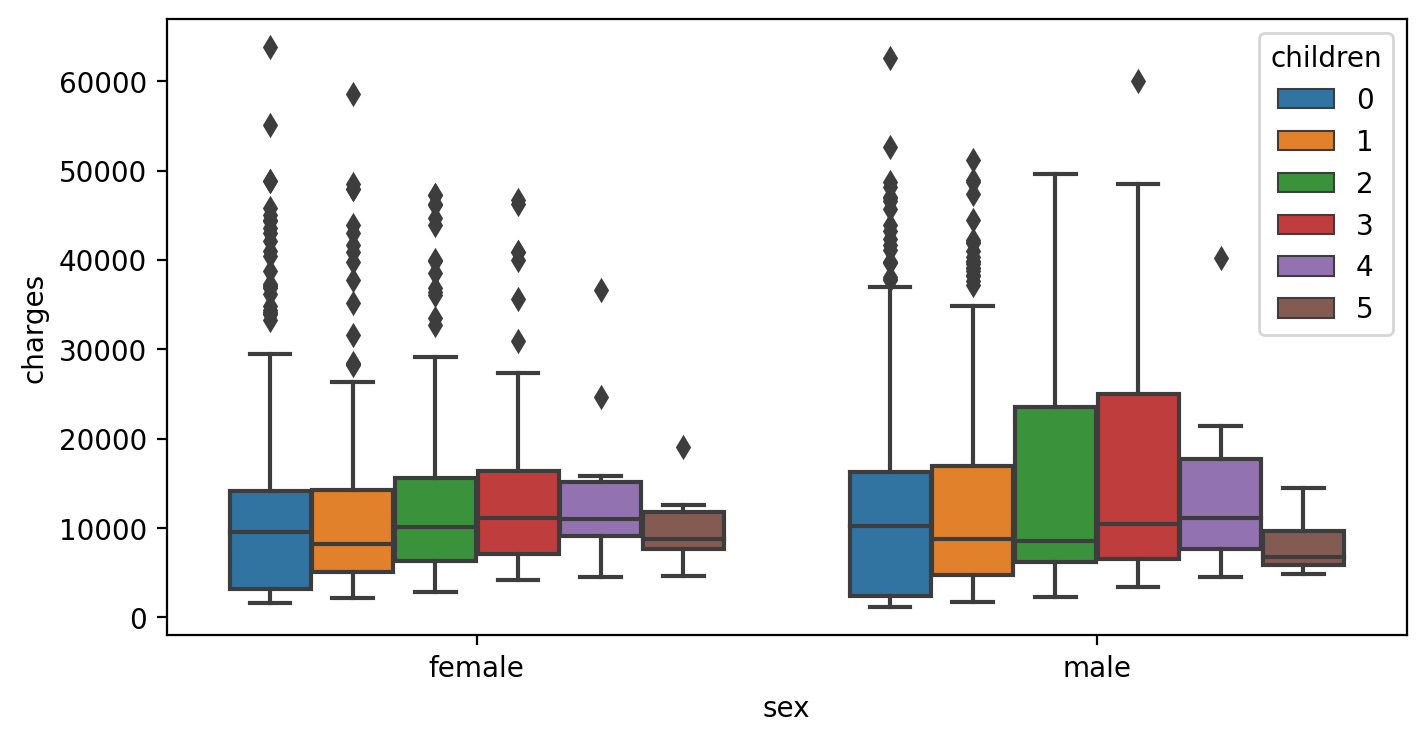

In [89]:
plt.figure(figsize=(8,4),dpi=200)
sns.boxplot(data=df1,x='sex',y='charges',hue='children')
plt.show()

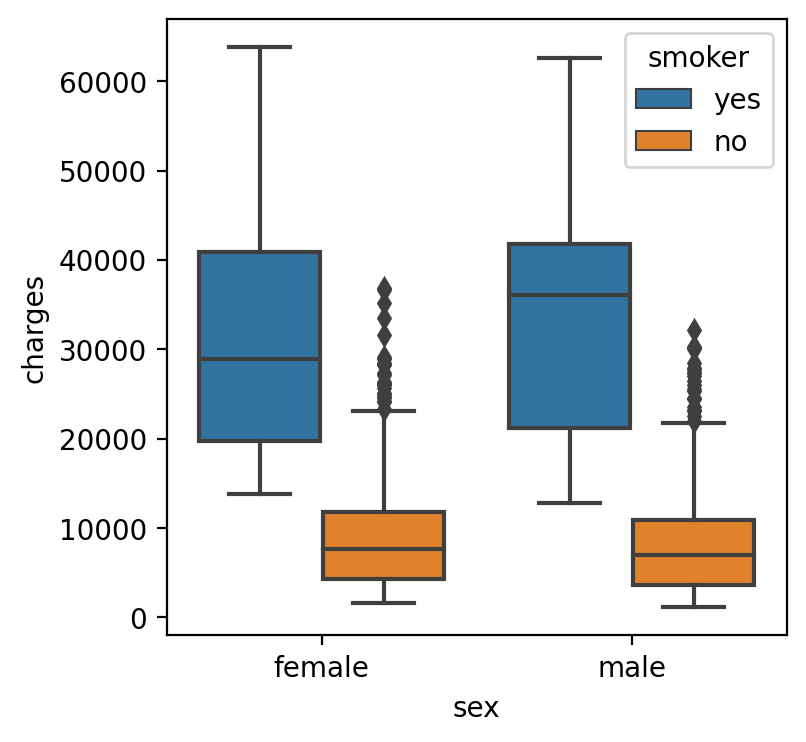

In [28]:
plt.figure(figsize=(4,4),dpi=200)
sns.boxplot(data=df1,x='sex',y='charges',hue='smoker')
plt.show()

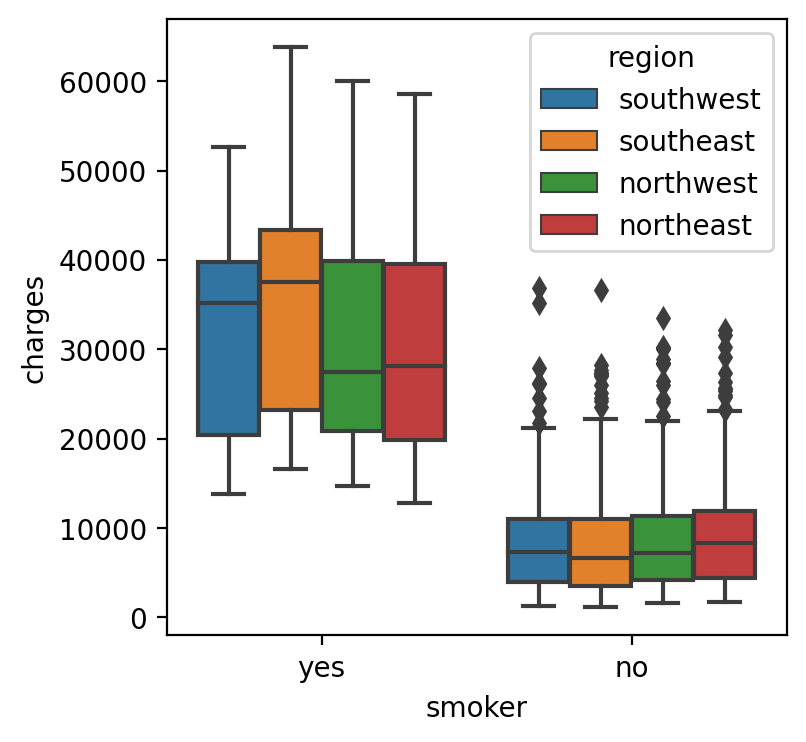

In [84]:
plt.figure(figsize=(4,4),dpi=200)
sns.boxplot(data=df1,x='smoker',y='charges',hue='region')
plt.show()

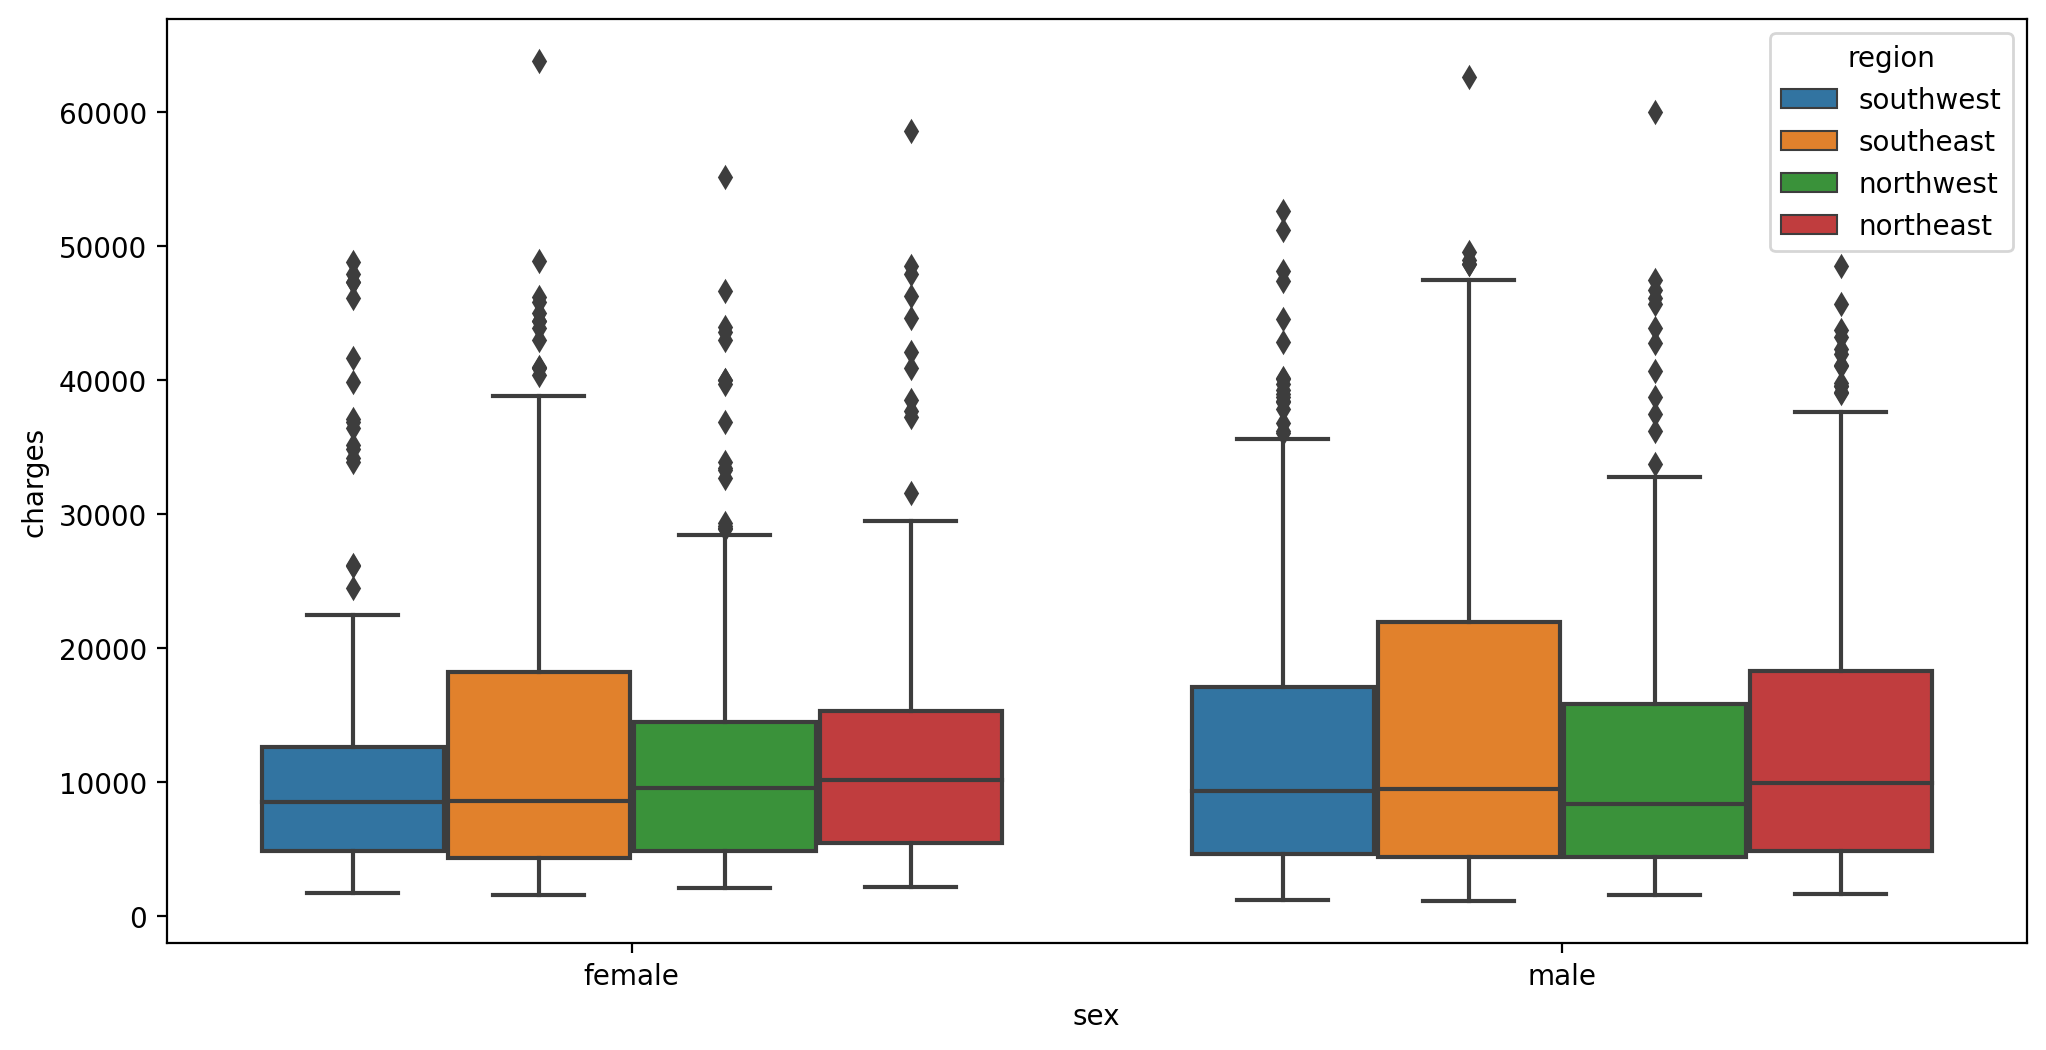

In [25]:
plt.figure(figsize=(12,6),dpi=200)
sns.boxplot(data=df1,x='sex',y='charges',hue='region')
plt.show()

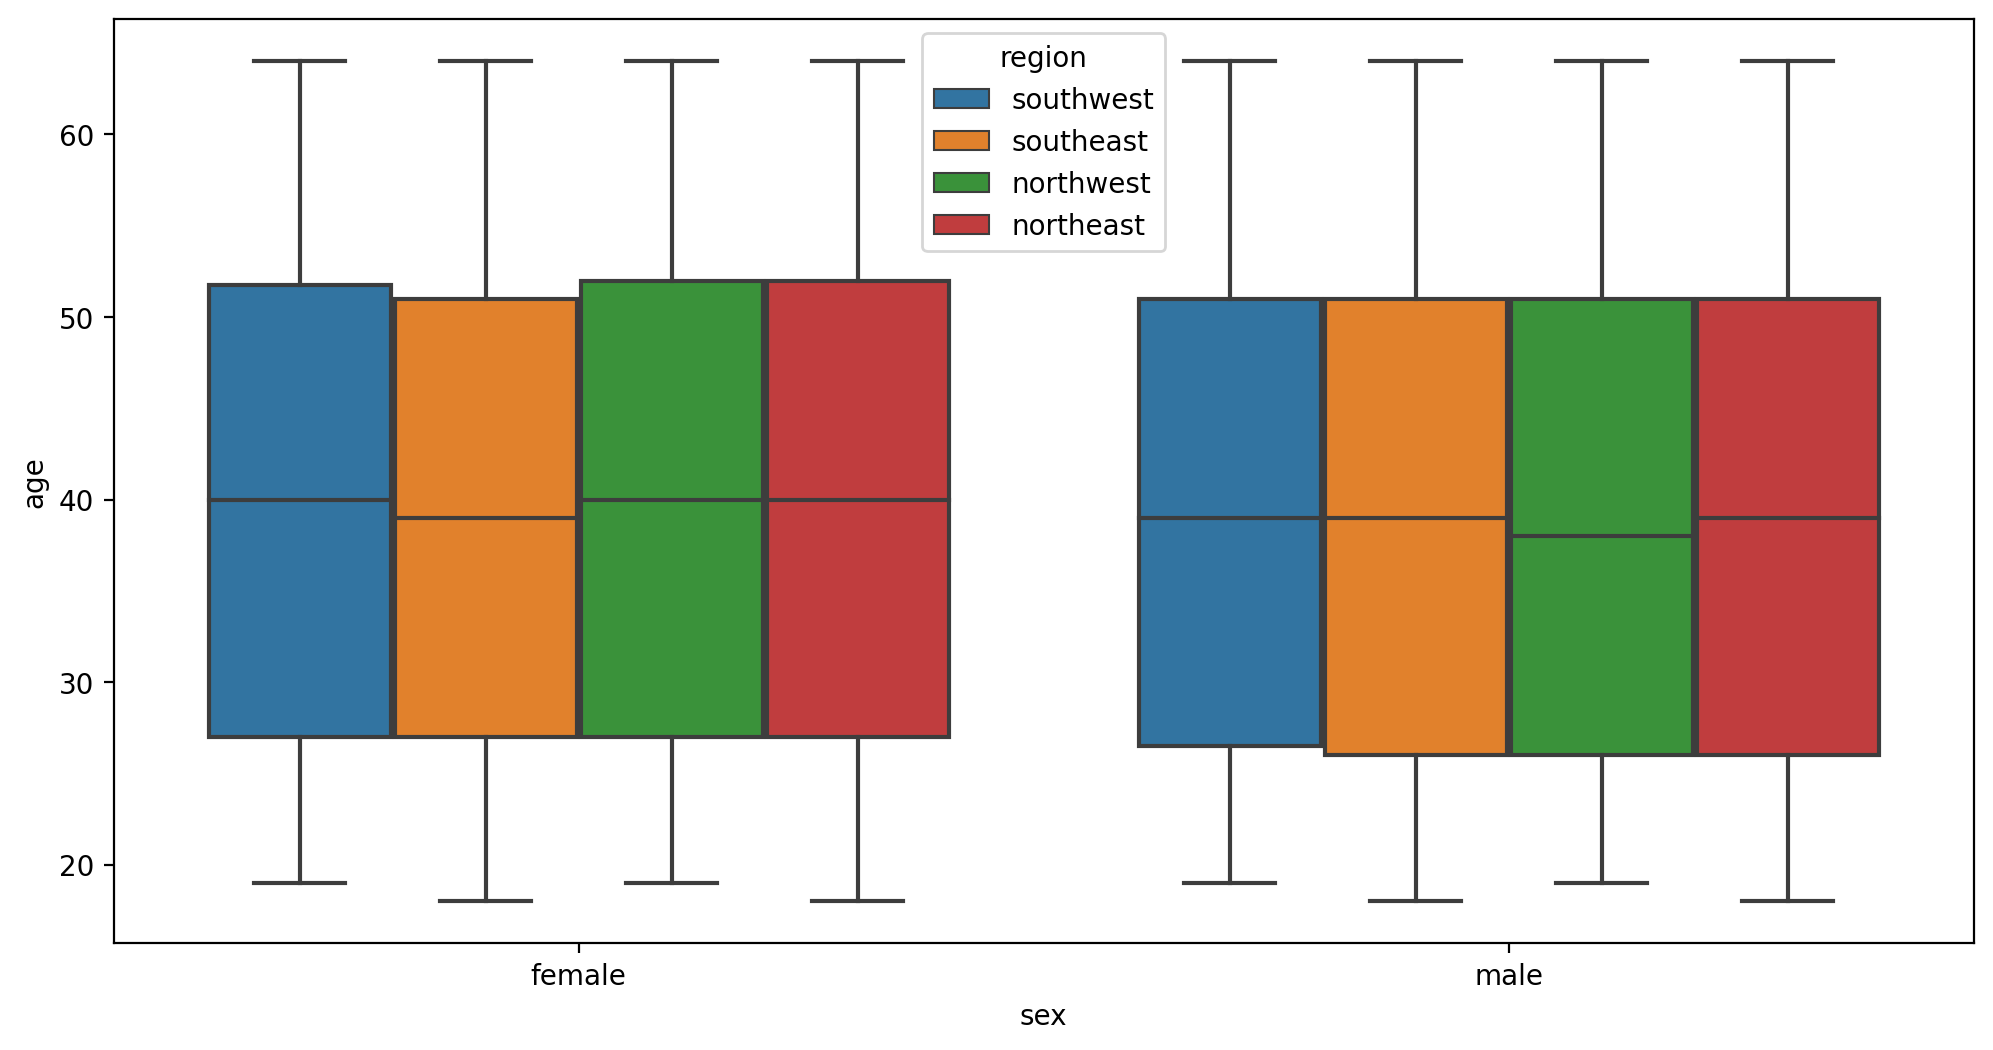

In [92]:
plt.figure(figsize=(12,6),dpi=200)
sns.boxplot(data=df1,x='sex',y='age',hue='region')
plt.show()

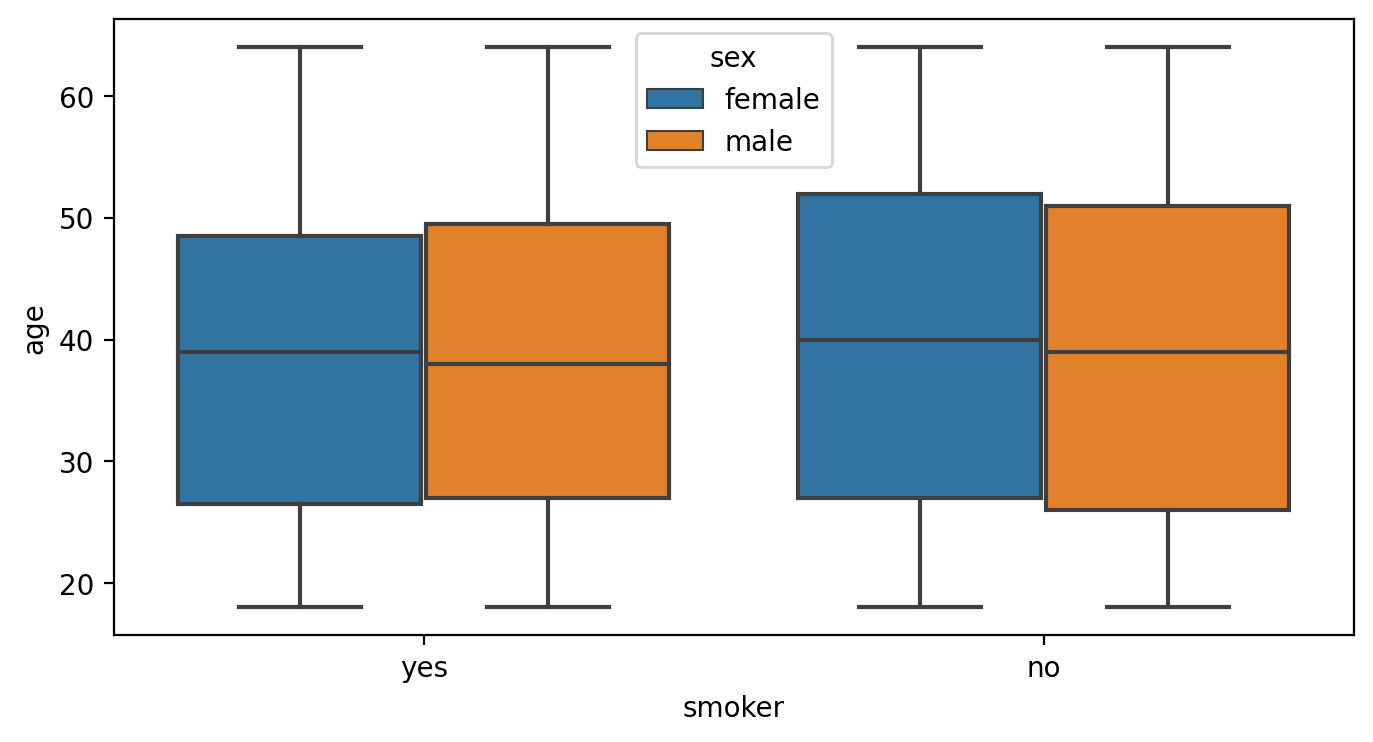

In [95]:
plt.figure(figsize=(8,4),dpi=200)
sns.boxplot(data=df1,x='smoker',y='age',hue='sex')
plt.show()

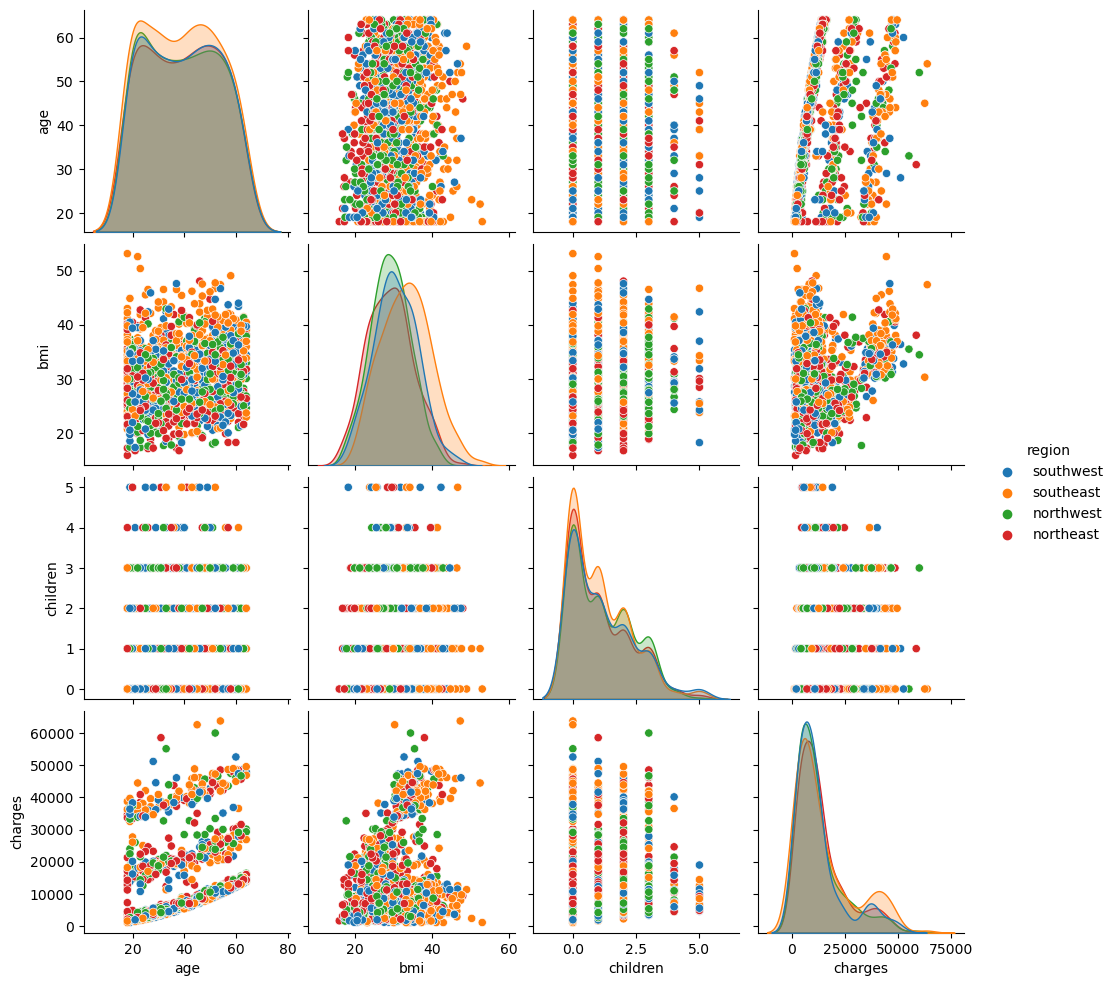

In [79]:
sns.pairplot(df1,hue='region')
plt.show()

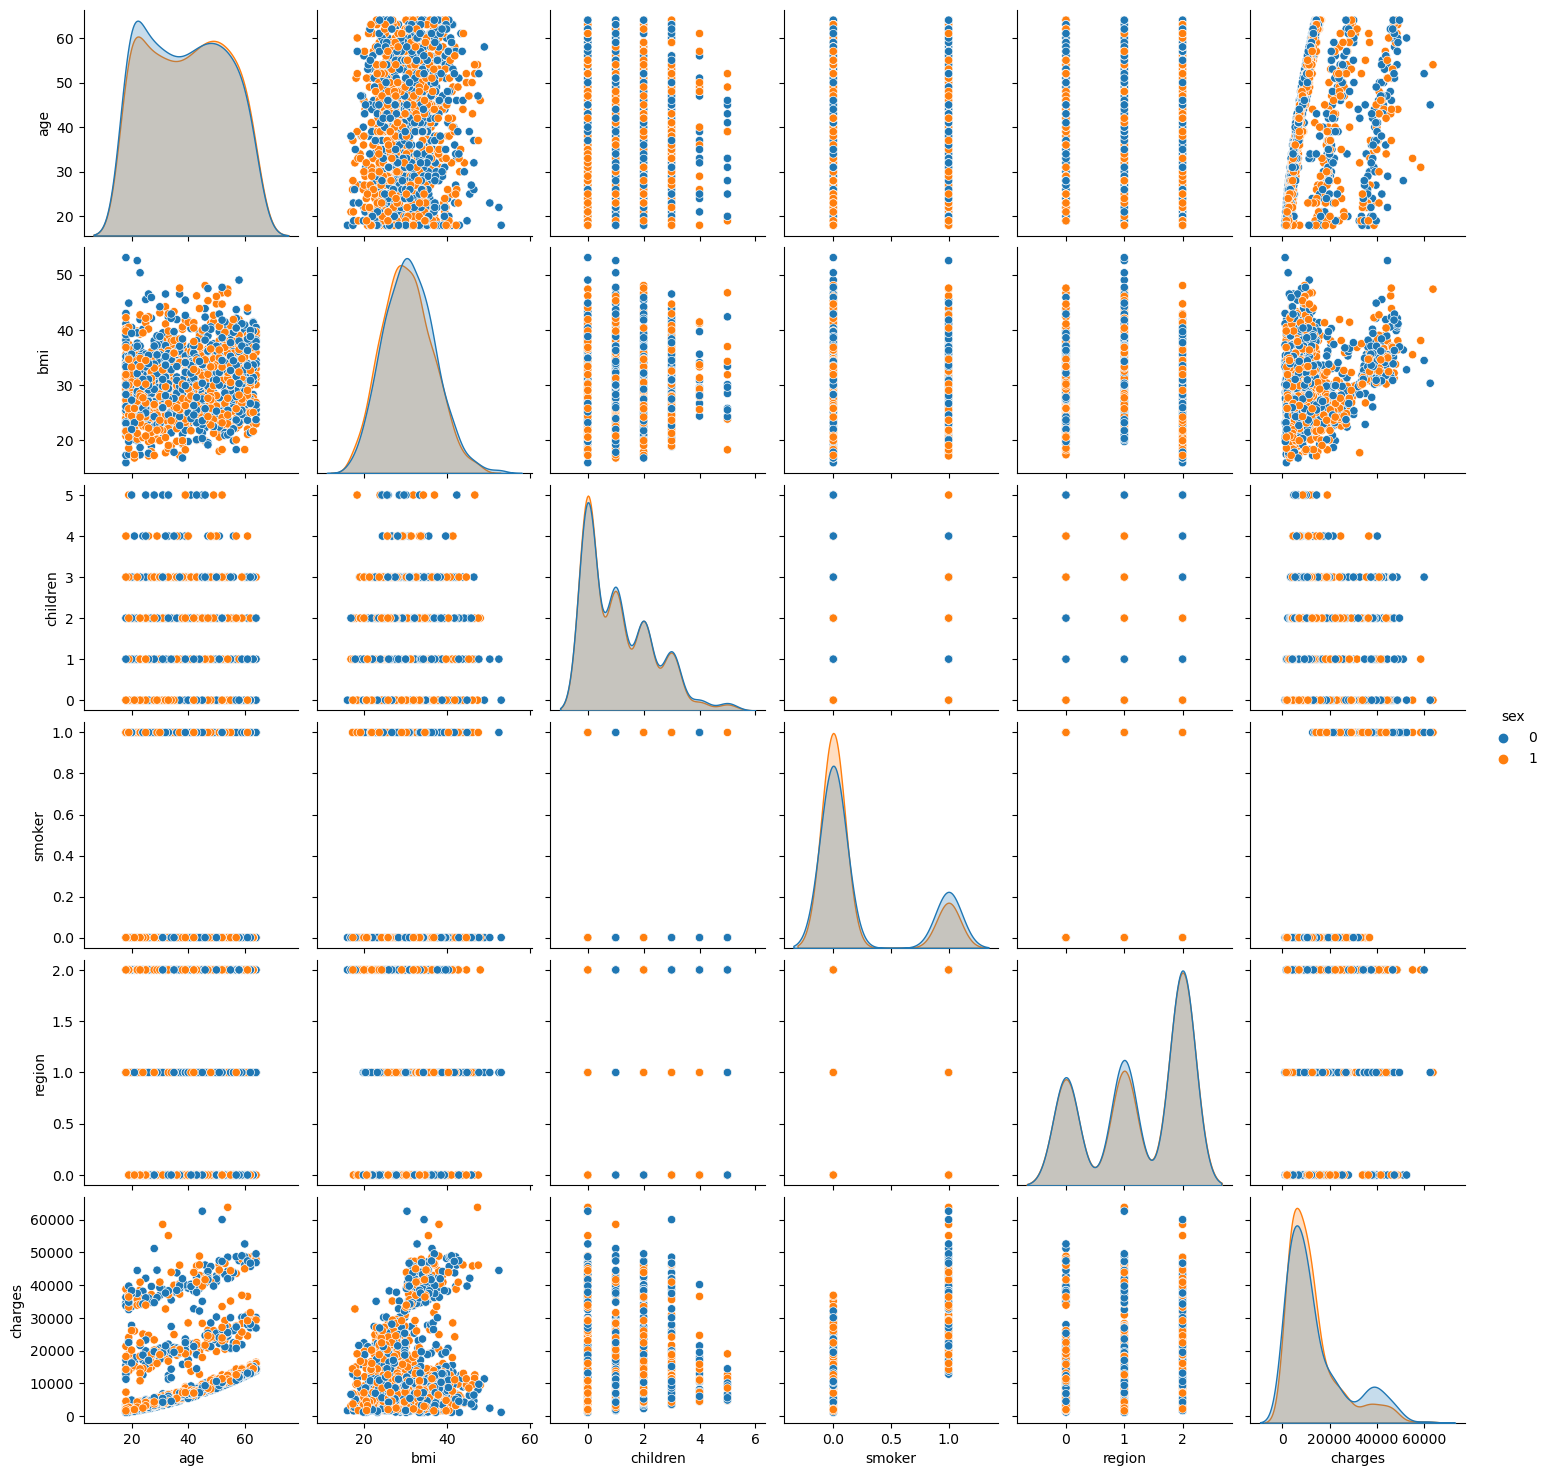

In [58]:
sns.pairplot(df1_encoded,hue='sex')
plt.show()

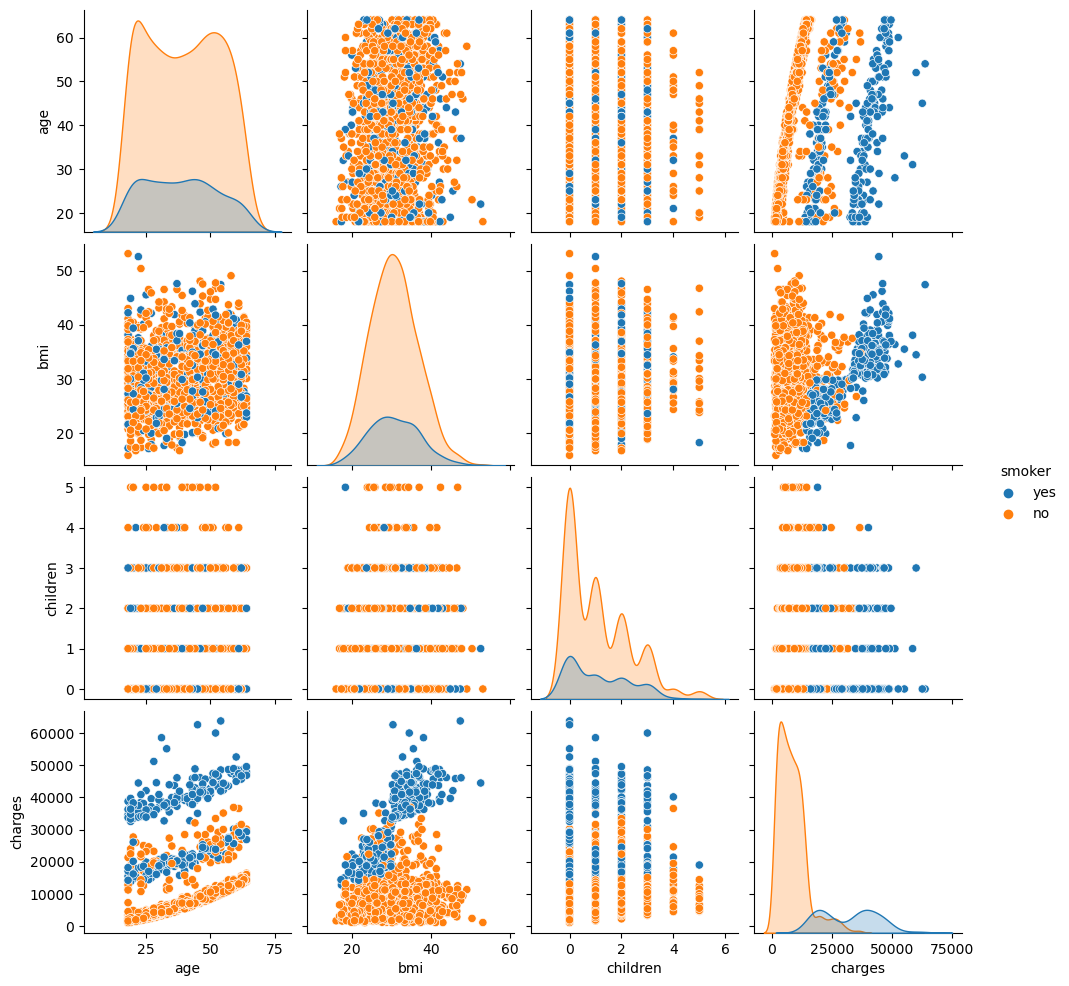

In [97]:
sns.pairplot(df1,hue='smoker')
plt.show()

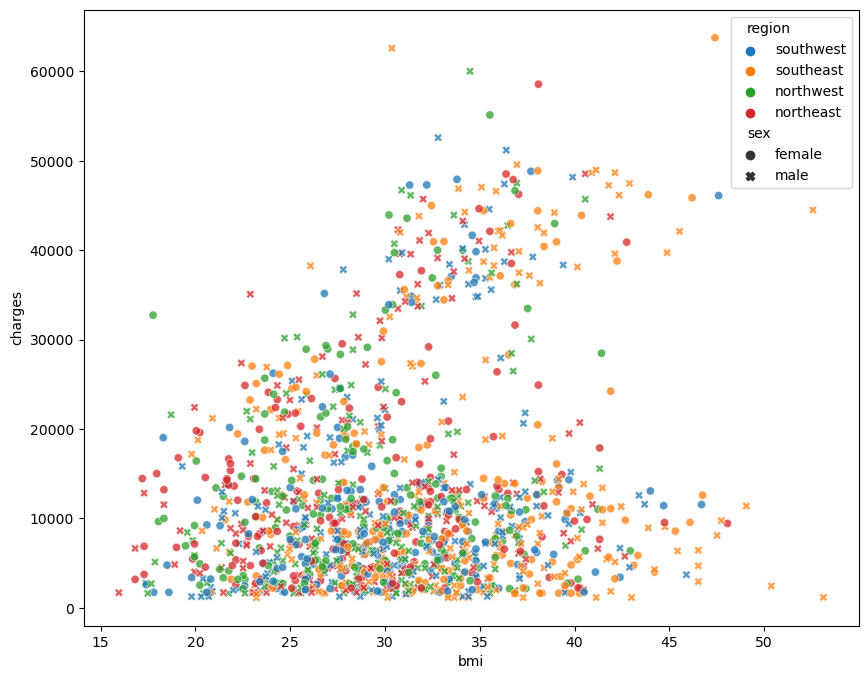

In [87]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df1,x='bmi',y='charges',hue='region',style='sex',alpha=.75)
plt.show()

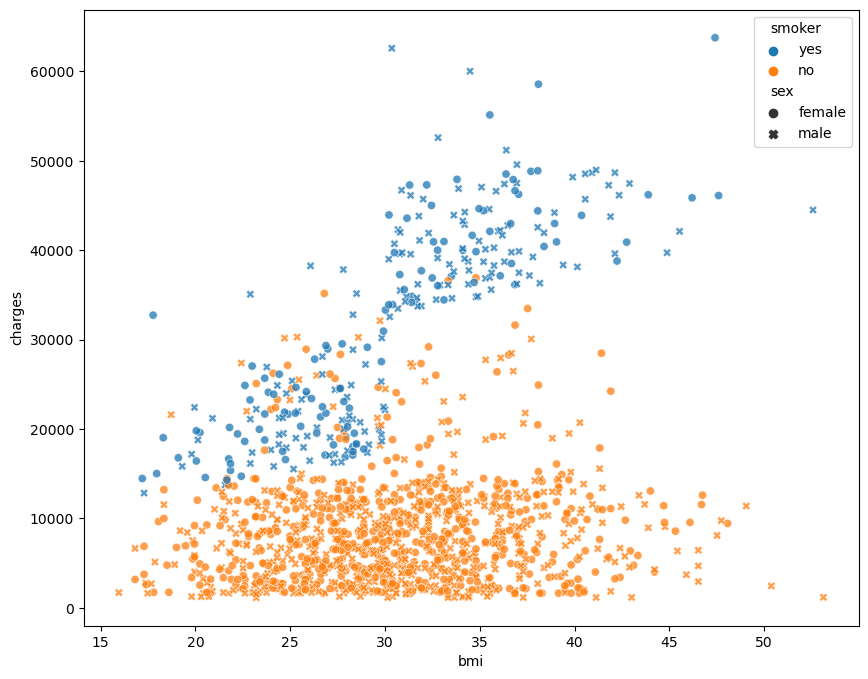

In [86]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df1,x='bmi',y='charges',hue='smoker',style='sex',alpha=.75)
plt.show()

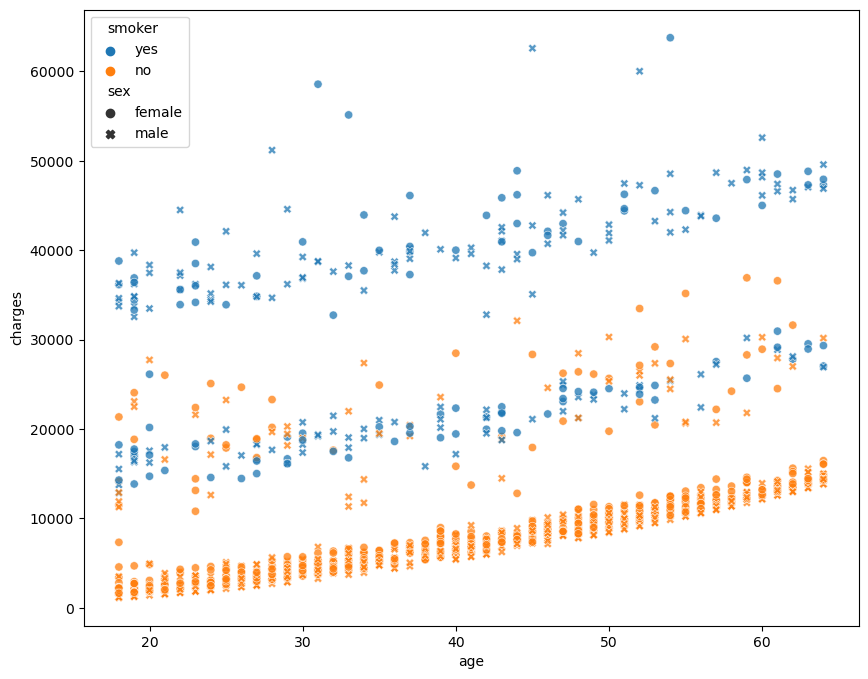

In [96]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df1,x='age',y='charges',hue='smoker',style='sex',alpha=.75)
plt.show()

# ANOVA

In [106]:
pg.anova(df1,dv='charges',between=['sex','smoker','region',],detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,sex,4.997237e+06,1.0,4.997237e+06,0.091079,7.628570e-01,0.000069
1,smoker,1.194010e+11,1.0,1.194010e+11,2176.194139,1.251080e-281,0.622091
2,region,1.058769e+08,3.0,3.529229e+07,0.643235,5.872675e-01,0.001458
3,sex * smoker,4.104282e+08,1.0,4.104282e+08,7.480434,6.320673e-03,0.005627
4,sex * region,1.382281e+06,3.0,4.607604e+05,0.008398,9.989439e-01,0.000019
5,smoker * region,1.329653e+09,3.0,4.432176e+08,8.078051,2.469612e-05,0.018001
6,sex * smoker * region,7.517058e+07,3.0,2.505686e+07,0.456684,7.126143e-01,0.001035
7,Residual,7.253404e+10,1322.0,5.486690e+07,NaN,NaN,NaN


In [36]:
pg.pairwise_tukey(df1,dv='charges',between=['sex',])

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,female,male,12569.578844,13956.751178,-1387.172334,661.330881,-2.097547,0.036133,-0.114629


In [37]:
pg.pairwise_tukey(df1,dv='charges',between=['region',])

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,northeast,northwest,13406.384516,12417.575374,988.809142,948.626254,1.042359,0.724524,0.088466
1,northeast,southeast,13406.384516,14735.411438,-1329.026921,922.907126,-1.440044,0.474505,-0.104003
2,northeast,southwest,13406.384516,12346.937377,1059.447139,948.626254,1.116822,0.679209,0.092763
3,northwest,southeast,12417.575374,14735.411438,-2317.836064,922.155616,-2.513498,0.058294,-0.182498
4,northwest,southwest,12417.575374,12346.937377,70.637997,947.895135,0.074521,0.999852,0.006234
5,southeast,southwest,14735.411438,12346.937377,2388.474060,922.155616,2.590099,0.047690,0.185107


In [99]:
pg.pairwise_tukey(df1,dv='charges',between=['smoker',])

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,no,yes,8434.268298,32050.231832,-23615.963534,506.07529,-46.664921,0.0,-3.159574


# OLS REGRESSION

In [104]:
ols_model = sm.OLS(endog=df1_ohe_hot.charges,exog=sm.add_constant(df1_ohe_hot.drop('charges',axis=1))).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     334.7
Date:                Mon, 20 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:33:10   Log-Likelihood:                -13545.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1325   BIC:                         2.718e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -9107.9678   1565.617     -5.817      0.000   -1.22e+04   -6036.608
age                257.1933     11.914     21.587      0.000     233.820     280.567
bmi                336.9088     28.612     11.775      0.000     280.779     393.039
sex_female         128.1616    332.834      0.385      0.700    -524.778     781.101
smoker_yes        2.384e+04    414.139     57.557      0.000     2.3e+04    2.46e+04
region_southwest  -952.8878    478.153     -1.993      0.046   -1890.908     -14.867
region_southeast -1033.1375    479.139     -2.156      0.031   -1973.091     -93.184
region_northwest  -380.0439    476.559     -0.797      0.425   -1314.936     554.848
children_0       -2947.3680   1239.163     -2.379      0.018   -5378.304    -516.432
children_1       -2556.3897   1258.939     -2.031      0.042   -5026.121     -86.659
children_3       -1983.0277   1306.765     -1.518      0.129   -4546.581     580.526
children_2       -1311.5907   1274.953     -1.029      0.304   -3812.737    1189.556
children_5       -1831.3284   1877.598     -0.975      0.330   -5514.718    1852.061
==============================================================================
Omnibus:                      293.990   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              695.789
Skew:                           1.191   Prob(JB):                    8.15e-152
Kurtosis:                       5.609   Cond. No.                         955.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
ols_rmse = np.sqrt(np.mean(ols_model.resid**2))
ols_rmse

6029.268613373612

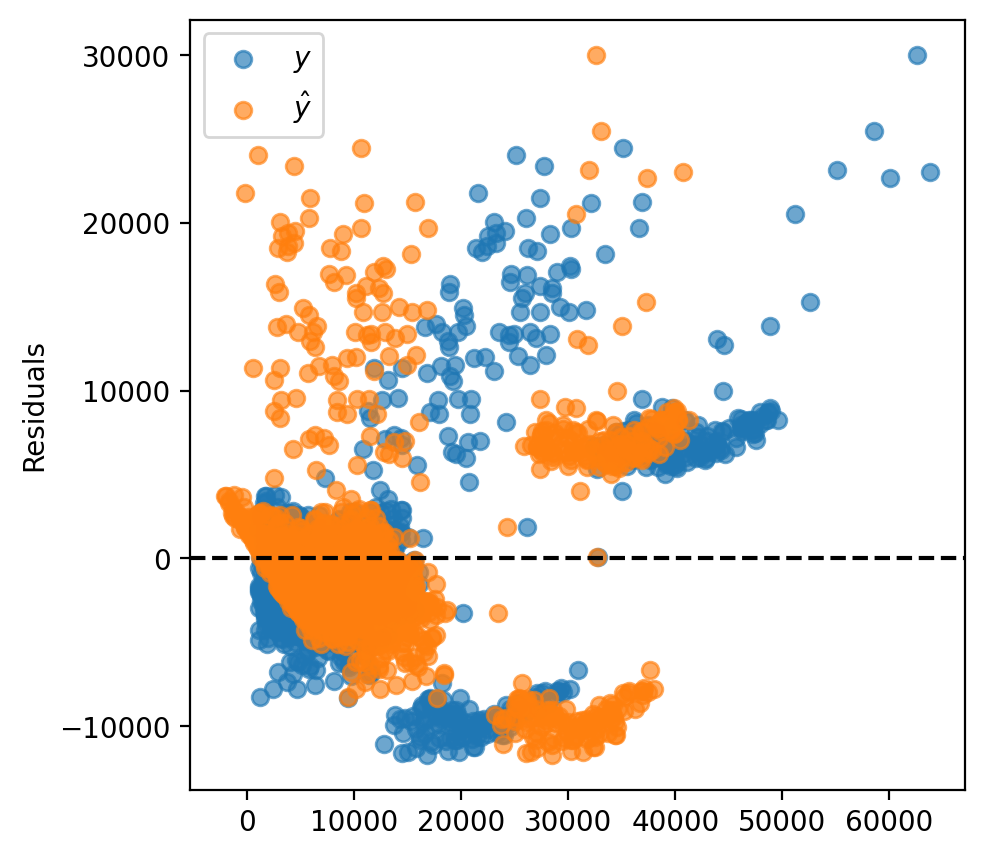

In [116]:
plt.figure(figsize=(5,5),dpi=200)
plt.scatter(df1_ohe_hot.charges,ols_model.resid,label='$y$',alpha=.65)
plt.scatter(ols_model.predict(),ols_model.resid,label='$\\hat{y}$',alpha=.65)
plt.axhline(0,c='k',ls='--')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [117]:
df1_ohe_hot.columns

Index(['age', 'bmi', 'charges', 'sex_female', 'smoker_yes', 'region_southwest',
       'region_southeast', 'region_northwest', 'children_0', 'children_1',
       'children_3', 'children_2', 'children_5'],
      dtype='object')

In [118]:
df1_ohe_hot['sex*smoker'] = df1_ohe_hot.sex_female*df1_ohe_hot.smoker_yes
df1_ohe_hot['region_sw*smoker'] = df1_ohe_hot.region_southwest*df1_ohe_hot.smoker_yes
df1_ohe_hot['region_se*smoker'] = df1_ohe_hot.region_southeast*df1_ohe_hot.smoker_yes
df1_ohe_hot['region_nw*smoker'] = df1_ohe_hot.region_northwest*df1_ohe_hot.smoker_yes

In [119]:
ols_model2 = sm.OLS(endog=df1_ohe_hot.charges,exog=sm.add_constant(df1_ohe_hot.drop('charges',axis=1))).fit()
ols_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     260.6
Date:                Mon, 20 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:44:24   Log-Likelihood:                -13525.
No. Observations:                1338   AIC:                         2.708e+04
Df Residuals:                    1321   BIC:                         2.717e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -8760.7309   1552.266     -5.644      0.000   -1.18e+04   -5715.556
age                256.5441     11.770     21.797      0.000     233.455     279.633
bmi                332.5167     28.267     11.763      0.000     277.063     387.970
sex_female         594.6370    366.928      1.621      0.105    -125.189    1314.463
smoker_yes        2.208e+04    901.890     24.486      0.000    2.03e+04    2.39e+04
region_southwest -1715.4341    524.299     -3.272      0.001   -2743.984    -686.884
region_southeast -2283.5380    533.599     -4.280      0.000   -3330.332   -1236.744
region_northwest  -526.0588    523.138     -1.006      0.315   -1552.330     500.213
children_0       -2837.0077   1223.840     -2.318      0.021   -5237.890    -436.125
children_1       -2377.7753   1244.511     -1.911      0.056   -4819.209      63.658
children_3       -1824.5301   1290.769     -1.414      0.158   -4356.711     707.651
children_2       -1272.7094   1258.437     -1.011      0.312   -3741.463    1196.045
children_5       -1464.2437   1853.783     -0.790      0.430   -5100.923    2172.436
sex*smoker       -2057.0291    823.540     -2.498      0.013   -3672.618    -441.440
region_sw*smoker  3725.3781   1200.571      3.103      0.002    1370.144    6080.612
region_se*smoker  5478.8008   1095.585      5.001      0.000    3329.524    7628.078
region_nw*smoker   540.4121   1196.591      0.452      0.652   -1807.013    2887.837
==============================================================================
Omnibus:                      326.791   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              864.809
Skew:                           1.271   Prob(JB):                    1.62e-188
Kurtosis:                       6.008   Cond. No.                         956.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
ols_rmse2 = np.sqrt(np.mean(ols_model2.resid**2))
ols_rmse2

5937.948766102527

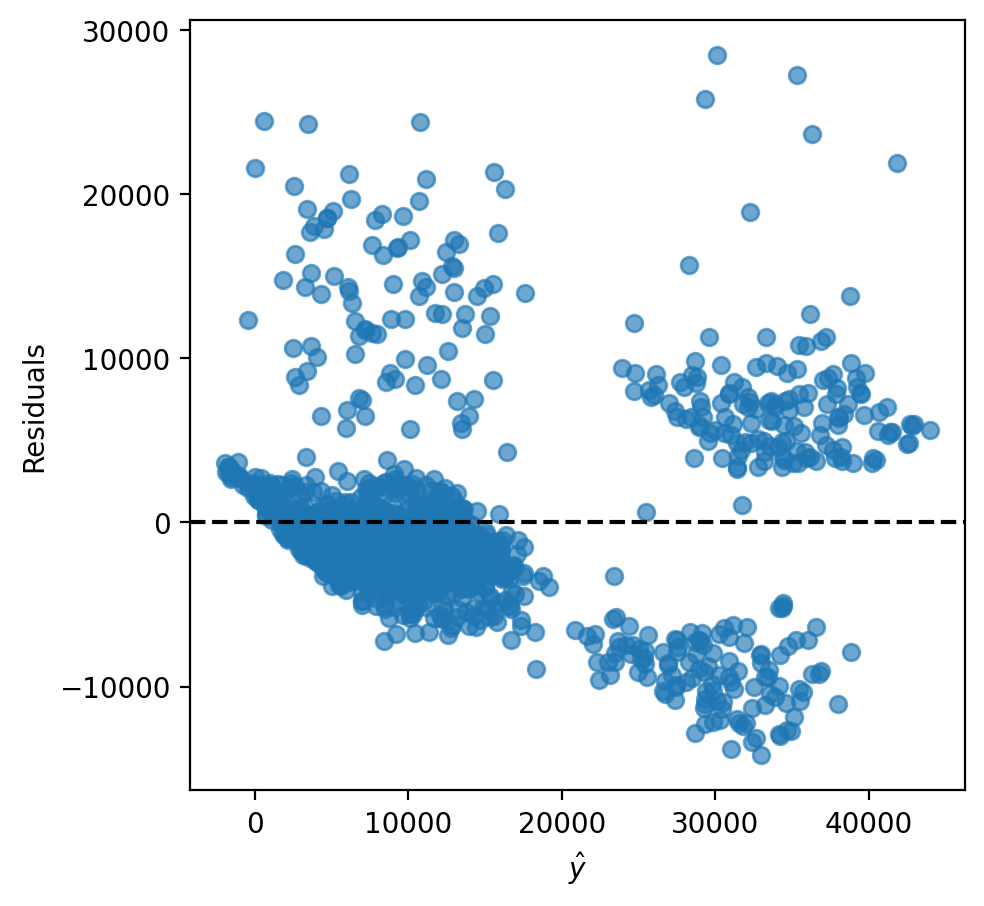

In [141]:
plt.figure(figsize=(5,5),dpi=200)
plt.scatter(ols_model2.predict(),ols_model2.resid,alpha=.65)
plt.axhline(0,c='k',ls='--')
plt.ylabel('Residuals')
plt.xlabel('$\\hat{y}$')
plt.show()

# XGBOOST

In [135]:
X=df1_mean_encoded
y=df1.charges

xgbr = XGBRegressor(n_jobs=-1)

params = dict(
    n_estimators = stats.randint(100,1500),
    max_depth = stats.randint(10,100),
    learning_rate = stats.uniform(0.000001,.5),
    gamma = stats.uniform(0.000001,10),
    subsample = stats.uniform(0.5,(1-.5)),
)

In [136]:
%%time

rand_search = RandomizedSearchCV(
    estimator = xgbr,
    param_distributions = params,
    n_iter = 50,
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
).fit(X,y)

y_preds = rand_search.predict(X)

xgbr_r2_1 = r2_score(y_true=y,y_pred=y_preds)
xgbr_rmse_1 = mean_squared_error(y_true=y,y_pred=y_preds,squared=False)

print(f'R2: {xgbr_r2_1:.3f}')
print(f'RMSE: {xgbr_rmse_1:,.3f}')

R2: 0.999
RMSE: 442.373
CPU times: total: 1min 6s
Wall time: 6min 35s


In [166]:
rand_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=4.1178621787912135, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02601131245700286, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=67, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1246, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [169]:
best_estimator = dict(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=4.1178621787912135, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02601131245700286, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=67, max_leaves=None,
             min_child_weight=None, missing='nan', monotone_constraints=None,
             n_estimators=1246, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None)

In [172]:
pd.DataFrame(best_estimator,index=[0]).T

,0
base_score,None
booster,None
callbacks,None
colsample_bylevel,None
colsample_bynode,None
colsample_bytree,None
early_stopping_rounds,None
enable_categorical,False
eval_metric,None
feature_types,None


In [176]:
best_params = rand_search.best_params_
pd.DataFrame(best_params,index=[0]).T

,0
gamma,4.117862
learning_rate,0.026011
max_depth,67.000000
n_estimators,1246.000000
subsample,0.624265


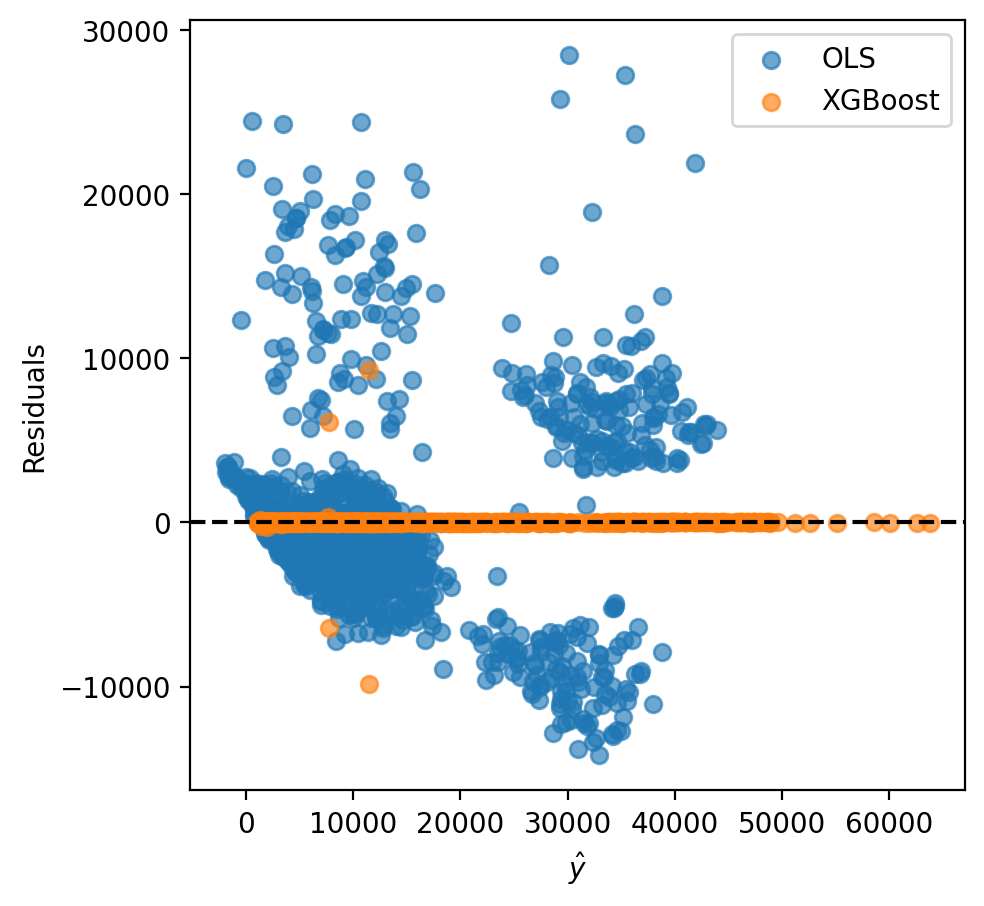

In [147]:
resids = y_preds - y

plt.figure(figsize=(5,5),dpi=200)
plt.scatter(ols_model2.predict(),ols_model2.resid,alpha=.65,label='OLS')
plt.scatter(y_preds,resids,alpha=0.65,c='tab:orange',label='XGBoost')
plt.axhline(0,c='k',ls='--')
plt.ylabel('Residuals')
plt.xlabel('$\\hat{y}$')
plt.legend()
plt.show()

In [178]:
xgbr_2 = XGBRegressor(n_jobs=-1, **rand_search.best_params_).fit(X,y)

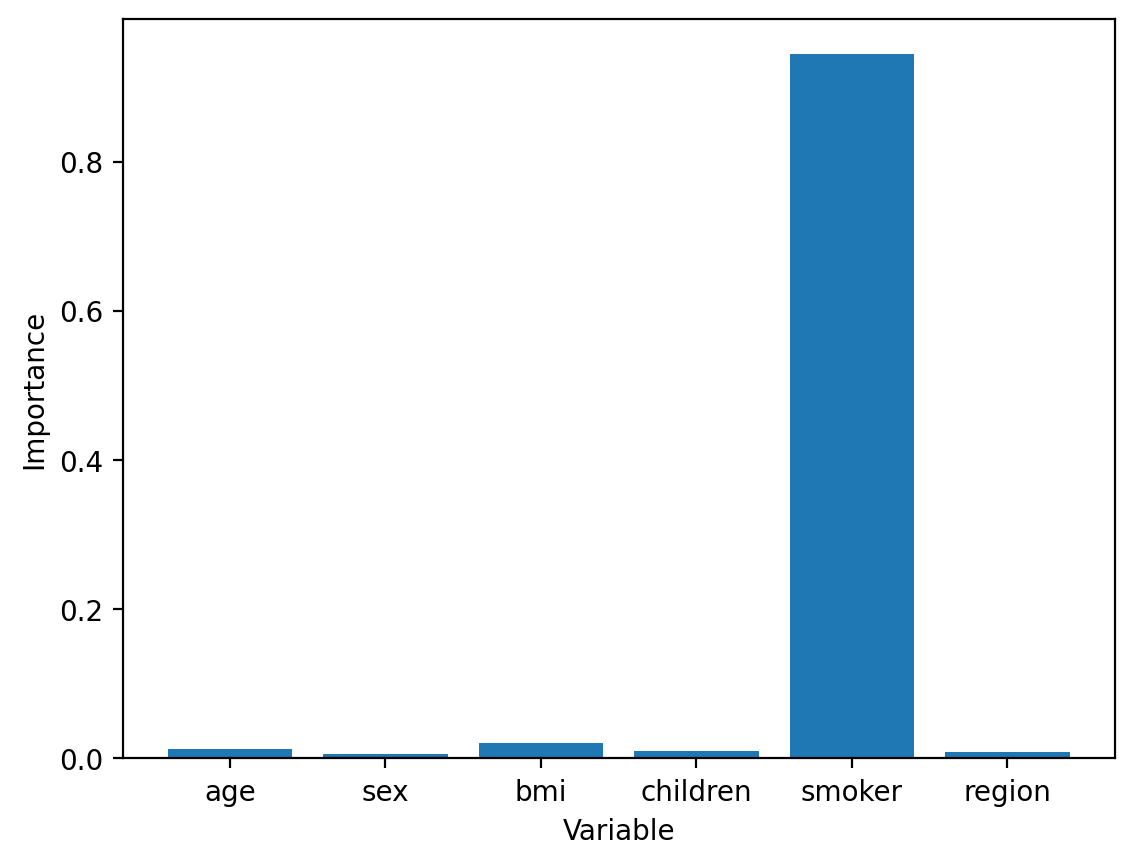

In [188]:
plt.figure(dpi=200)
plt.bar(x=X.columns,height=xgbr_2.feature_importances_)
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.show()